In [1]:
%load_ext autoreload
%autoreload 

In [2]:
from sdf_clip import SDFCLIP

In [3]:
sdf_clip = SDFCLIP(
    prompt="Mesh of a bunny rabbit rendered with zbrush maya",
    out_img_width=256,
    out_img_height=256,
    use_single_cam=True,
    is_jupyter=True,
)

ClipLoss device cuda





image loss:  tensor(-16.4219, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
image weight:  tensor(65536)

sdf loss:  tensor(0.2570, device='cuda:0', grad_fn=<MulBackward0>)
sdf weight:  tensor(512)

lp loss:  tensor(0.5711, device='cuda:0', grad_fn=<MulBackward0>)
lp weight:  tensor(512)

loss:  tensor(-15.5938, device='cuda:0', grad_fn=<AddBackward0>)

STD: None

AVG: tensor(-15.5905)

sdf grid res: 8  - iteration: 4  -  cam view idx 0  -  cam iters: 1



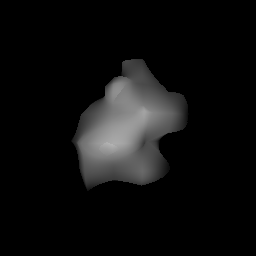

RuntimeError: The size of tensor a (8) must match the size of tensor b (16) at non-singleton dimension 2

In [4]:
sdf_grid = sdf_clip.run(
    learning_rate = 0.03,
    image_loss_weight = 1 / 1000,
    sdf_loss_weight = 1 / 1000,
    lp_loss_weight = 1 / 1000,
    max_std_res_loss = 0.8,
    num_std_res_samples = 3,
    max_num_iters_per_camera = 1,
)

In [ ]:
sdf_grid.shape

In [ ]:
import numpy as np

In [ ]:
np.save('bunny_grid.npy', sdf_grid.detach().cpu().numpy())

In [ ]:
import math
import time

import torch
from PIL import Image
from IPython.display import display, clear_output

from sdf_utils import generate_image

In [ ]:
Tensor = torch.cuda.FloatTensor
camera_angle_list = [
    Tensor([0, 0, 5]),  # 0
    Tensor([0.1, 5, 0]),
    Tensor([5, 0, 0]),
    Tensor([0, 0, -5]),
    Tensor([0.1, -5, 0]),
    Tensor([-5, 0, 0]),  # 5
    Tensor([5 / math.sqrt(2), 0, 5 / math.sqrt(2)]),
    Tensor([5 / math.sqrt(2), 5 / math.sqrt(2), 0]),
    Tensor([0, 5 / math.sqrt(2), 5 / math.sqrt(2)]),
    Tensor([-5 / math.sqrt(2), 0, -5 / math.sqrt(2)]),
    Tensor([-5 / math.sqrt(2), -5 / math.sqrt(2), 0]),  #10
    Tensor([0, -5 / math.sqrt(2), -5 / math.sqrt(2)]),
    Tensor([-5 / math.sqrt(2), 0, 5 / math.sqrt(2)]),
    Tensor([-5 / math.sqrt(2), 5 / math.sqrt(2), 0]),
    Tensor([0, -5 / math.sqrt(2), 5 / math.sqrt(2)]),
    Tensor([5 / math.sqrt(2), 0, -5 / math.sqrt(2)]),
    Tensor([5 / math.sqrt(2), -5 / math.sqrt(2), 0]),
    Tensor([0, 5 / math.sqrt(2), -5 / math.sqrt(2)]),
    Tensor([5 / math.sqrt(3), 5 / math.sqrt(3), 5 / math.sqrt(3)]),
    Tensor([5 / math.sqrt(3), 5 / math.sqrt(3), -5 / math.sqrt(3)]),
    Tensor([5 / math.sqrt(3), -5 / math.sqrt(3), 5 / math.sqrt(3)]),
    Tensor([-5 / math.sqrt(3), 5 / math.sqrt(3), 5 / math.sqrt(3)]),
    Tensor([-5 / math.sqrt(3), -5 / math.sqrt(3), 5 / math.sqrt(3)]),
    Tensor([-5 / math.sqrt(3), 5 / math.sqrt(3), -5 / math.sqrt(3)]),
    Tensor([5 / math.sqrt(3), -5 / math.sqrt(3), -5 / math.sqrt(3)]),
    Tensor([-5 / math.sqrt(3), -5 / math.sqrt(3), -5 / math.sqrt(3)])
]

In [ ]:
num_cameras = 26
camera_angle_list = [
    torch.tensor([5 * math.cos(a), 0, 5 * math.sin(a)]).cuda()
    for a in np.linspace(0, math.pi / 4, num_cameras)
]

In [ ]:
bounding_box_min_x = -2.
bounding_box_min_y = -2.
bounding_box_min_z = -2.
bounding_box_max_x = 2.
bounding_box_max_y = 2.
bounding_box_max_z = 2

grid_res_x = grid_res_y = grid_res_z = sdf_grid.shape[0]
voxel_size = torch.tensor([4. / (grid_res_x - 1)]).cuda()

out_img_width = 512
out_img_height = 512

for cam in range(num_cameras):
    image_initial = generate_image(
        bounding_box_min_x,
        bounding_box_min_y,
        bounding_box_min_z,
        bounding_box_max_x,
        bounding_box_max_y,
        bounding_box_max_z,
        voxel_size,
        grid_res_x,
        grid_res_y,
        grid_res_z,
        out_img_width,
        out_img_height,
        sdf_grid,
        camera_angle_list[cam],
    )
    
    clear_output(wait=True)
    
    image_initial_array = image_initial.detach().cpu().numpy() * 255
    display(Image.fromarray(image_initial_array.astype(np.uint8)))
    print(camera_angle_list[cam])
    time.sleep(0.4)